In [1]:
import sys
sys.path.insert(1, "/HOME1/users/students/shvl/projects/spatiotemporal")

%matplotlib widget

from sen12mscrts_manager import Sen12mscrtsDatasetManager
from torch_datasets.minimal_dataset import S1Dataset
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interactive
import ipywidgets as widgets
from os.path import join
import xarray as xr
xr.set_options(display_expand_data=False)

In [2]:
root_dir='/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS'
cloud_maps_dir="/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS_cloud_maps"
cloud_histograms_csv = join(cloud_maps_dir, "cloud_histograms.csv")

In [3]:
dataset_manager = Sen12mscrtsDatasetManager(
    root_dir=root_dir,
    cloud_maps_dir=cloud_maps_dir,
    cloud_histograms_csv=cloud_histograms_csv
)

In [4]:
dataset_manager_path = join(dataset_manager.project_directory, "config", "dataset_manager.csv")

# dataset_manager.load_dataset()
# dataset_manager.save_to_file(dataset_manager_path)
dataset_manager.load_from_file(dataset_manager_path)

# Select parameters for rescaling

In [5]:
default_quantile_max = 0.995
default_quantile_min = 0.005
default_margin_min = 0.0
default_margin_max = 0.25

In [6]:
S1_histograms = xr.load_dataset(
    join(dataset_manager.project_directory, "stats", "S1_train_dataset_histogram.nc")
)
S1_histograms = S1_histograms["Sentinel-1 histogram [dB]"]

S1_histograms

<xarray.DataArray 'Sentinel-1 histogram [dB]' (Polarization: 2,
                                               Backscatter: 6000)>
12821 97 90 88 75 86 780 91 81 ... 1229 1165 1219 1151 1148 1170 1159 353972
Coordinates:
  * Backscatter     (Backscatter) float64 -49.99 -49.98 -49.97 ... 9.985 9.995
    left_bin_edge   (Backscatter) float64 -50.0 -49.99 -49.98 ... 9.97 9.98 9.99
    right_bin_edge  (Backscatter) float64 -49.99 -49.98 -49.97 ... 9.99 10.0
  * Polarization    (Polarization) object 'VV' 'VH'
Attributes:
    subset:   train

In [7]:
S1_histograms_norm = S1_histograms / S1_histograms.sum(dim="Backscatter")

In [8]:
S1_histograms_cummulative = S1_histograms_norm.cumsum(dim="Backscatter")
S1_histograms_cummulative

<xarray.DataArray 'Sentinel-1 histogram [dB]' (Polarization: 2,
                                               Backscatter: 6000)>
6.414e-07 6.463e-07 6.508e-07 6.552e-07 6.589e-07 ... 1.0 1.0 1.0 1.0 1.0
Coordinates:
  * Backscatter     (Backscatter) float64 -49.99 -49.98 -49.97 ... 9.985 9.995
    left_bin_edge   (Backscatter) float64 -50.0 -49.99 -49.98 ... 9.97 9.98 9.99
    right_bin_edge  (Backscatter) float64 -49.99 -49.98 -49.97 ... 9.99 10.0
  * Polarization    (Polarization) object 'VV' 'VH'

In [9]:
# In contrast to Sentinel-2, the cummulative distribution of values for Sentinel-1 is continuous in nature, not discrete
# Value stored in the cummulative histogram corresponds to the true CDF value at the right edge of the corresponding bin

max_quantile_backscatter = {
    "VV": S1_histograms.right_bin_edge[np.searchsorted(S1_histograms_cummulative.sel(Polarization="VV"), v=default_quantile_max)].item(),
    "VH": S1_histograms.right_bin_edge[np.searchsorted(S1_histograms_cummulative.sel(Polarization="VH"), v=default_quantile_max)].item()
}
min_quantile_backscatter = {
    "VV": S1_histograms.right_bin_edge[np.searchsorted(S1_histograms_cummulative.sel(Polarization="VV"), v=default_quantile_min)].item(),
    "VH": S1_histograms.right_bin_edge[np.searchsorted(S1_histograms_cummulative.sel(Polarization="VH"), v=default_quantile_min)].item()
}
d_quantile_backscatter = {
    "VV": max_quantile_backscatter["VV"]- min_quantile_backscatter["VV"],
    "VH": max_quantile_backscatter["VH"]- min_quantile_backscatter["VH"]
}

max_quantile_backscatter["VV"], min_quantile_backscatter["VV"], d_quantile_backscatter["VV"]

(2.4100000000000037, -26.31, 28.720000000000002)

In [10]:
original_bin_edges = np.append(S1_histograms.left_bin_edge, S1_histograms.right_bin_edge[-1])
original_bin_edges

array([-50.  , -49.99, -49.98, ...,   9.98,   9.99,  10.  ])

In [11]:
rescaled_bin_edges = {
    "VV": (original_bin_edges - min_quantile_backscatter["VV"]) / d_quantile_backscatter["VV"],
    "VH": (original_bin_edges - min_quantile_backscatter["VH"]) / d_quantile_backscatter["VH"]
}
rescaled_bin_edges["VV"], rescaled_bin_edges["VH"]

(array([-0.82486072, -0.82451253, -0.82416435, ...,  1.26357939,
         1.26392758,  1.26427577]),
 array([-0.06271024, -0.06246997, -0.0622297 , ...,  1.37842383,
         1.3786641 ,  1.37890437]))

### Plot histograms for rescaling

In [12]:
with plt.ioff():
    fig_1 = plt.figure(constrained_layout=True, figsize=(13, 5))
    grid_1 = fig_1.add_gridspec(ncols=2, nrows=2, width_ratios=[10, 3])
    ax_1_stairs = fig_1.add_subplot(grid_1[:, 0])
    ax_1_residuals = {
        "VV": fig_1.add_subplot(grid_1[0, 1]),
        "VH": fig_1.add_subplot(grid_1[1, 1])
    }

In [13]:
stairplots_1 = {}

for polarization in ax_1_residuals.keys():
    stairplots_1[polarization] = ax_1_stairs.stairs(
        values=S1_histograms_norm.loc[polarization] * d_quantile_backscatter[polarization],
        edges=rescaled_bin_edges[polarization],
        alpha=0.5,
        color="lightsteelblue" if polarization=="VV" else "orange",
        edgecolor="steelblue" if polarization=="VV" else "red",
        fill=True,
        linewidth=0.5,
        label=polarization
    )

In [14]:
ax_1_stairs.set_ylim(bottom=0, top=0.07)
ax_1_stairs.set_xlim(left=-0.3, right=1.3)
ax_1_stairs.set_ylabel("PDF pixels")
ax_1_stairs.set_xlabel("Rescaled reflectance")
ax_1_stairs.set_title(f"Sentinel-1 dataset histogram", fontsize=14)
ax_1_stairs.legend(title="Polarization")

for polarization, ax in ax_1_residuals.items():
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0, decimals=1))
    ax.set_ylim(bottom=0, top=0.02)
    ax.set_xticks(ticks=range(2), labels=["min", "max"])
    ax.set_xlim(left=-1, right=2)
    ax.set_title(f"{polarization} Residuals", fontsize=14)

In [15]:
ax_1_stairs.axvline(0.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)
ax_1_stairs.axvline(1.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)
min_margin_line_1 = ax_1_stairs.axvline(0.0, color="gray", linestyle="dotted", alpha=0.5)
max_margin_line_1 = ax_1_stairs.axvline(1.0, color="gray", linestyle="dotted", alpha=0.5)

In [16]:
bin_width = 0.8

residuals_1 = {
    "low": {}, 
    "high": {}
}

for polarization, ax in ax_1_residuals.items():
    
    residuals_1["low"][polarization] = ax.add_patch(
        mpl.patches.Rectangle(
            xy=(-bin_width/2, 0),
            height=0.01,
            width=0.8,
            color="lightsteelblue" if polarization=="VV" else "orange"
        )
    )
    residuals_1["high"][polarization] = ax.add_patch(
        mpl.patches.Rectangle(
            xy=(1-bin_width/2, 0),
            height=0.01,
            width=0.8,
            color="steelblue" if polarization=="VV" else "red"
        )
    )

In [17]:
original_bin_edges = np.append(S1_histograms.left_bin_edge, S1_histograms.right_bin_edge[-1])

def update_image_1(min_quantile, max_quantile, max_margin, min_margin):

    for polarization in ax_1_residuals.keys():

        cummulative_histogram = S1_histograms_cummulative.sel(Polarization=polarization)

        # sometimes searchsorted will fail for max_quantile=1 because of imprecise float comparison. Catch that error here
        try:
            max_quantile_backscatter = cummulative_histogram.right_bin_edge[np.searchsorted(cummulative_histogram, v=max_quantile, side="right")].item()
        except IndexError:
            max_quantile_backscatter = cummulative_histogram.right_bin_edge[-1].item()

        # catch edge case where min_quantile=0
        if min_quantile < 0 or np.isclose(min_quantile, 0):
            min_quantile_backscatter = cummulative_histogram.left_bin_edge[0].item()
        else:
            min_quantile_backscatter = cummulative_histogram.right_bin_edge[np.searchsorted(cummulative_histogram, v=min_quantile, side="right")].item()
            
        d_quantile_backscatter = max_quantile_backscatter - min_quantile_backscatter
        d_margin = 1 - max_margin - min_margin

        # Calculate new min-max values using margins
        min_backscatter_new = min_quantile_backscatter - d_quantile_backscatter * (min_margin / d_margin)
        max_backscatter_new = min_backscatter_new + (d_quantile_backscatter / d_margin)

        low_residual = (
            0 if min_backscatter_new < cummulative_histogram.Backscatter[0] 
            else cummulative_histogram[np.searchsorted(cummulative_histogram.Backscatter, v=min_backscatter_new)]
        )
        high_residual = (
            0 if max_backscatter_new > cummulative_histogram.Backscatter[-1] 
            else 1 - cummulative_histogram[np.searchsorted(cummulative_histogram.Backscatter, v=max_backscatter_new)]
        )
        
        # rescaled_coordinates_margin = (np.arange(band_histogram.size + 1)[np.newaxis, :] - min_values_new) / (d_new)
        rescaled_coordinates = (original_bin_edges - min_quantile_backscatter) / (d_quantile_backscatter)
        rescaled_coordinates_margin = min_margin + (rescaled_coordinates * d_margin)
        
        min_margin_line_1.set(xdata=min_margin)
        max_margin_line_1.set(xdata=1-max_margin)
    
        stairplots_1[polarization].set_data(edges=rescaled_coordinates_margin, values=S1_histograms_norm.loc[polarization] * d_quantile_backscatter)
        residuals_1["high"][polarization].set_height(high_residual)
        residuals_1["low"][polarization].set_height(low_residual)

In [18]:
slider_min_quantile = widgets.FloatSlider(
    value=default_quantile_min,
    min=0.0,
    max=0.04,
    step=0.0001,
    description='Min:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)
slider_max_quantile = widgets.FloatSlider(
    value=default_quantile_max,
    min=0.95,
    max=1.00,
    step=0.0001,
    description='Max:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)
slider_max_margin = widgets.FloatSlider(
    value=default_margin_max,
    min=0.0,
    max=0.3,
    step=0.001,
    description='Max margin:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)
slider_min_margin = widgets.FloatSlider(
    value=default_margin_min,
    min=0,
    max=0.3,
    step=0.001,
    description='Min margin:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)

sliders_quantile_widget = interactive(
    update_image_1, 
    min_quantile=slider_min_quantile,
    max_quantile=slider_max_quantile,
    max_margin=slider_max_margin,
    min_margin=slider_min_margin
)

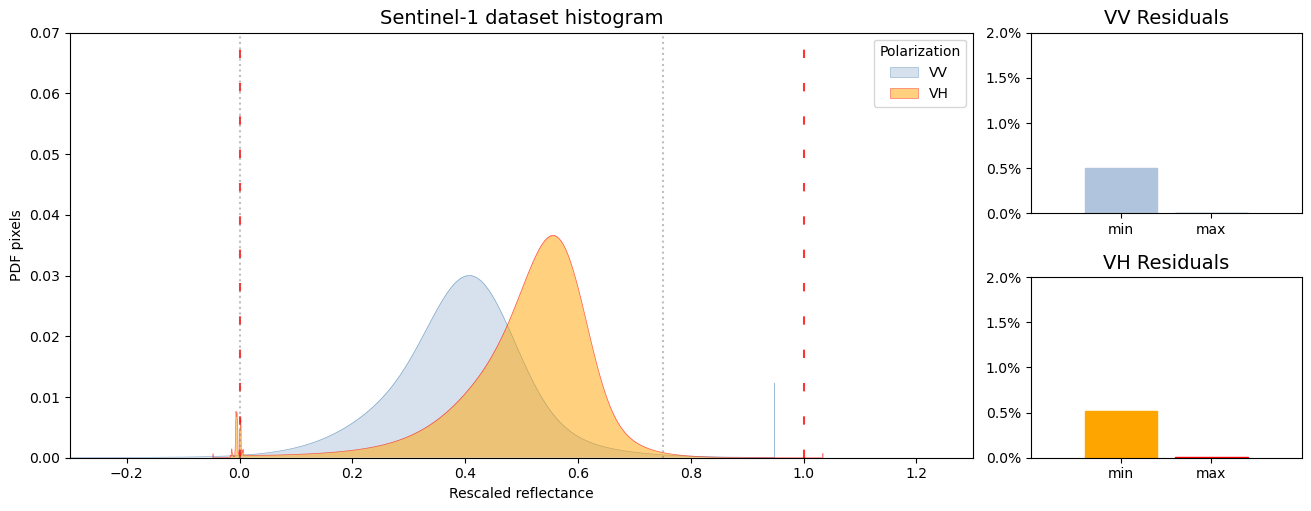

In [19]:
display(fig_1)
# display(fig_1.canvas, sliders_quantile_widget)

In [20]:
# plt.close(fig_1)

# Try mean-std rescaling instead

Min-max percentile rescaling does not work very well with Sentinel-1 data. We can try mean-std rescaling instead.

In [21]:
default_std_factor = 8.5

In [22]:
# no need to divide by dataset sum, as it is normalized already, so sum=1

mean_backscatter = {
    "VV": (S1_histograms_norm.sel(Polarization="VV") * S1_histograms_norm.Backscatter).sum().item(),
    "VH": (S1_histograms_norm.sel(Polarization="VH") * S1_histograms_norm.Backscatter).sum().item()
}

mean_backscatter

{'VV': -11.36917368130674, 'VH': -19.164954607219187}

In [23]:
# no need to divide by dataset sum, as it is normalized already, so sum=1

std_backscatter = {
    "VV": np.sqrt((((S1_histograms_norm.Backscatter - mean_backscatter["VV"]) ** 2) * S1_histograms_norm.sel(Polarization="VV")).sum()).item(),
    "VH": np.sqrt((((S1_histograms_norm.Backscatter - mean_backscatter["VH"]) ** 2) * S1_histograms_norm.sel(Polarization="VH")).sum()).item()
}

std_backscatter

{'VV': 4.707390714485409, 'VH': 6.490981719198543}

In [24]:
original_bin_edges = np.append(S1_histograms.left_bin_edge, S1_histograms.right_bin_edge[-1])
original_bin_edges

array([-50.  , -49.99, -49.98, ...,   9.98,   9.99,  10.  ])

In [25]:
with plt.ioff():
    fig_2 = plt.figure(constrained_layout=True, figsize=(13, 5))
    grid_2 = fig_2.add_gridspec(ncols=2, nrows=2, width_ratios=[10, 3])
    ax_2_stairs = fig_2.add_subplot(grid_2[:, 0])
    ax_2_residuals = {
        "VV": fig_2.add_subplot(grid_2[0, 1]),
        "VH": fig_2.add_subplot(grid_2[1, 1])
    }

In [26]:
stairplots_2 = {}

for polarization in ["VV", "VH"]:
    
    rescaled_bin_edges = 0.5 + (original_bin_edges - mean_backscatter[polarization]) / (std_backscatter[polarization] * default_std_factor)
    
    stairplots_2[polarization] = ax_2_stairs.stairs(
        values=S1_histograms_norm.loc[polarization] * std_backscatter[polarization] * default_std_factor,
        edges=rescaled_bin_edges,
        alpha=0.5,
        color="lightsteelblue" if polarization=="VV" else "orange",
        edgecolor="steelblue" if polarization=="VV" else "red",
        fill=True,
        linewidth=0.5,
        label=polarization
    )

In [27]:
ax_2_stairs.set_ylim(bottom=0, top=0.07)
ax_2_stairs.set_xlim(left=-0.3, right=1.3)
ax_2_stairs.set_ylabel("PDF pixels")
ax_2_stairs.set_xlabel("Rescaled reflectance")
ax_2_stairs.set_title(f"Sentinel-1 dataset histogram", fontsize=14)
ax_2_stairs.legend(title="Polarization")

for polarization, ax in ax_2_residuals.items():
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0, decimals=1))
    ax.set_ylim(bottom=0, top=0.02)
    ax.set_xticks(ticks=range(2), labels=["min", "max"])
    ax.set_xlim(left=-1, right=2)
    ax.set_title(f"{polarization} Residuals", fontsize=14)

In [28]:
ax_2_stairs.axvline(0.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)
ax_2_stairs.axvline(1.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)

In [29]:
bin_width = 0.8

residuals_2 = {
    "low": {}, 
    "high": {}
}

for polarization, ax in ax_2_residuals.items():
    
    residuals_2["low"][polarization] = ax.add_patch(
        mpl.patches.Rectangle(
            xy=(-bin_width/2, 0),
            height=0.01,
            width=0.8,
            color="lightsteelblue" if polarization=="VV" else "orange"
        )
    )
    residuals_2["high"][polarization] = ax.add_patch(
        mpl.patches.Rectangle(
            xy=(1-bin_width/2, 0),
            height=0.01,
            width=0.8,
            color="steelblue" if polarization=="VV" else "red"
        )
    )

In [30]:
original_bin_edges = np.append(S1_histograms.left_bin_edge, S1_histograms.right_bin_edge[-1])

def update_image_2(std_factor):

    for polarization in ["VV", "VH"]:
        
        rescaled_bin_edges = 0.5 + (original_bin_edges - mean_backscatter[polarization]) / (std_backscatter[polarization] * std_factor)
        rescaled_backscatter = 0.5 + (S1_histograms_norm.Backscatter.values - mean_backscatter[polarization]) / (std_backscatter[polarization] * std_factor)
        
        stairplots_2[polarization].set_data(
            edges=rescaled_bin_edges,
            values=S1_histograms_norm.loc[polarization] * std_backscatter[polarization] * std_factor
        )
        
        residuals_2["low"][polarization].set_height(
            0.0 if rescaled_backscatter[0] > 0 or np.isclose(rescaled_backscatter[0], 0) 
            else S1_histograms_cummulative.sel(Polarization=polarization)[np.searchsorted(rescaled_backscatter, v=0)]
        )
        residuals_2["high"][polarization].set_height(
            0.0 if rescaled_backscatter[-1] < 1 or np.isclose(rescaled_backscatter[-1], 1) 
            else 1 - S1_histograms_cummulative.sel(Polarization=polarization)[np.searchsorted(rescaled_backscatter, v=1)]
        )        

In [31]:
slider_std_factor = widgets.FloatSlider(
    value=default_std_factor,
    min=1,
    max=20,
    step=0.1,
    description='Std factor:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)

slider_std_factor_widget = interactive(
    update_image_2, 
    std_factor=slider_std_factor
)

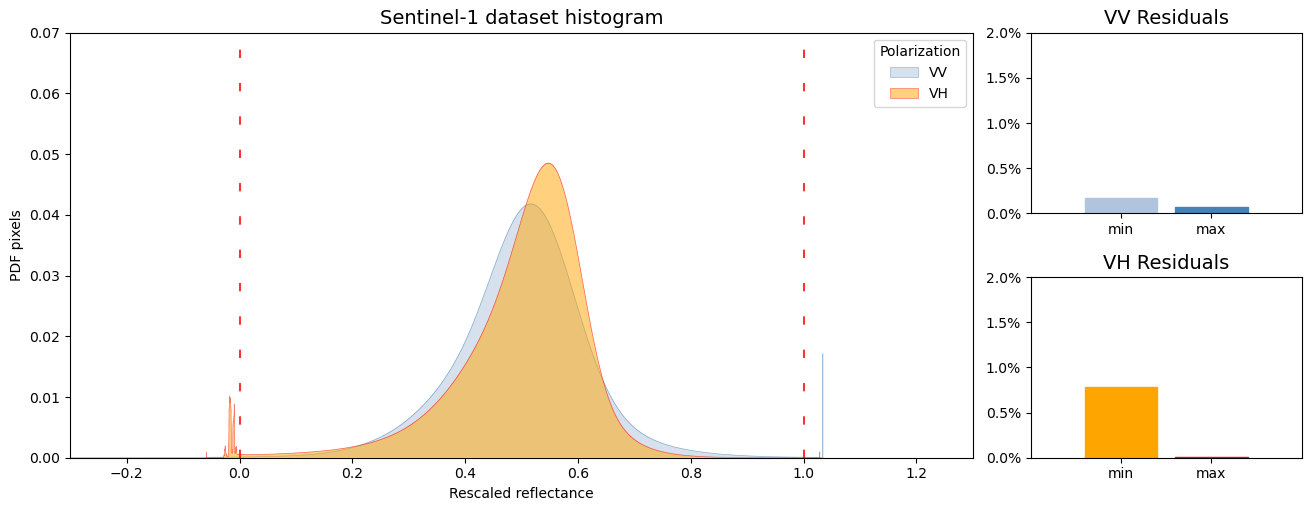

In [32]:
display(fig_2)
# display(fig_2.canvas, slider_std_factor_widget)

In [33]:
# plt.close(fig_2)

# Test results

In [34]:
std_factor = slider_std_factor.value
std_factor

8.5

In [35]:
min_backscatter = {
    "VV": -0.5 * (std_backscatter["VV"] * std_factor) + mean_backscatter["VV"],
    "VH": -0.5 * (std_backscatter["VH"] * std_factor) + mean_backscatter["VH"]
}
max_backscatter = {
    "VV": +0.5 * (std_backscatter["VV"] * std_factor) + mean_backscatter["VV"],
    "VH": +0.5 * (std_backscatter["VH"] * std_factor) + mean_backscatter["VH"]
}

min_backscatter, max_backscatter

({'VV': -31.37558421786973, 'VH': -46.751626913813},
 {'VV': 8.637236855256248, 'VH': 8.421717699374621})

In [36]:
with plt.ioff():
    fig_3, ax_3_stairs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(10, 5))

In [37]:
original_bin_edges = np.append(S1_histograms.left_bin_edge, S1_histograms.right_bin_edge[-1])

stairplots_3 = {}

for polarization in ["VV", "VH"]:
    
    rescaled_bin_edges = (original_bin_edges - min_backscatter[polarization]) / (max_backscatter[polarization] - min_backscatter[polarization])
    
    stairplots_3[polarization] = ax_3_stairs.stairs(
        values=S1_histograms_norm.loc[polarization] * (max_backscatter[polarization] - min_backscatter[polarization]),
        edges=rescaled_bin_edges,
        alpha=0.5,
        color="lightsteelblue" if polarization=="VV" else "orange",
        edgecolor="steelblue" if polarization=="VV" else "red",
        fill=True,
        linewidth=0.5,
        label=polarization
    )

ax_3_stairs.set_ylim(bottom=0, top=0.07)
ax_3_stairs.set_xlim(left=-0.3, right=1.3)
ax_3_stairs.set_ylabel("PDF pixels")
ax_3_stairs.set_xlabel("Rescaled reflectance")
ax_3_stairs.set_title(f"Sentinel-1 dataset histogram", fontsize=14)
ax_3_stairs.legend(title="Polarization")

ax_3_stairs.axvline(0.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)
ax_3_stairs.axvline(1.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)

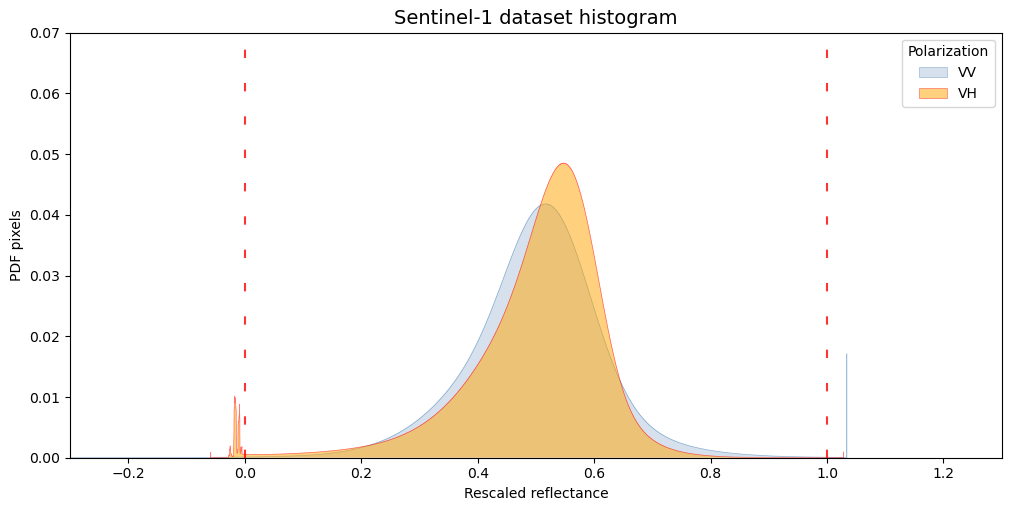

In [38]:
display(fig_3)

In [39]:
# plt.close(fig_3)

# Save results

In [40]:
s1_min_max = pd.DataFrame(
    data=[[min_backscatter["VV"], max_backscatter["VV"]],
          [min_backscatter["VH"], max_backscatter["VH"]]],
    columns=["min", "max"],
    index=pd.Index([0, 1], name="band")
)

s1_min_max

,min,max
band,,
0,-31.375584,8.637237
1,-46.751627,8.421718


In [41]:
s1_min_max.to_csv(join(dataset_manager.project_directory, "stats", "S1_min_max.csv"))

In [42]:
s1_min_max_saved = pd.read_csv(join(dataset_manager.project_directory, "stats", "S1_min_max.csv"), index_col="band")
s1_min_max_saved

,min,max
band,,
0,-31.375584,8.637237
1,-46.751627,8.421718


### Test rescaling

In [43]:
utils = dataset_manager.utils

In [44]:
random_state = np.random.RandomState(42)

random_indices = [
    dataset_manager.data.index[i]
    for i in random_state.randint(low=0, high=len(dataset_manager.data), size=(16))
]

In [45]:
original_S1_images = [
    utils.read_tif(dataset_manager.data.loc[index, "S1"])
    for index in random_indices
]

original_S1_images[0].shape, original_S1_images[0].min(), original_S1_images[0].max()

((2, 256, 256), -48.12547434594681, 11.678820718334444)

In [46]:
rescaled_S1_images = [
    utils.rescale_s1(image, clip=False)
    for image in original_S1_images
]

rescaled_S1_images[0].shape, rescaled_S1_images[0].min(), rescaled_S1_images[0].max()

((2, 256, 256), -0.024900564607160596, 1.076015231655861)

In [47]:
residuals_test = {
    "min": {
        "VV": np.mean([(image[0] < 0).mean() for image in rescaled_S1_images]),
        "VH": np.mean([(image[1] < 0).mean() for image in rescaled_S1_images])
    },
    "max": {
        "VV": np.mean([(image[0] > 1).mean() for image in rescaled_S1_images]),
        "VH": np.mean([(image[1] > 1).mean() for image in rescaled_S1_images])
    }
}

residuals_test

{'min': {'VV': 0.0054779052734375, 'VH': 0.023223876953125},
 'max': {'VV': 0.0006237030029296875, 'VH': 1.049041748046875e-05}}

### Plot images

In [52]:
from colorsys import hls_to_rgb, hsv_to_rgb

def s1_to_complex(s1_image, clip=False):
    
    if clip:
        s1_image = np.clip(s1_image, a_min=0, a_max=1)

    return s1_image[0] + 1j * s1_image[1]

def colorize(s1_image, hsv=False):

    rotation = np.cos(-np.pi/4) + 1j * np.sin(-np.pi/4)
    complex_image = s1_to_complex(s1_image, clip=True)
    complex_image = complex_image * rotation # rotate -45 degrees
    
    r = np.abs(complex_image) / np.sqrt(2)  # [0 .. 1]
    arg = np.angle(complex_image) / (np.pi/4)  # [-1 .. 1]

    h = 1/3 + (arg + 1) / 3  # np.clip(1/3 + (arg + 1) / 3, a_min=0, a_max=1)
    s = np.clip(np.abs(arg * 2), a_min=0, a_max=1)
    v = np.clip(r, a_min=0, a_max=1)

    if hsv:
        return np.stack([h,s,v], axis=-1)
        
    return np.stack(np.vectorize(hsv_to_rgb)(h,s,v), axis=-1)

In [53]:
with plt.ioff():
    fig_4, axs_4 = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), tight_layout=True)

In [54]:
for ax, image, index in zip(axs_4.flatten(), rescaled_S1_images, random_indices):
    ax.imshow(
        colorize(image)
    )
    ax.set_axis_off()
    ax.set_title(index)

### Plot coordinate scale

In [55]:
complex_coordinates = np.stack(
    np.meshgrid(
        np.arange(0, 1, step=0.01), 
        np.arange(1, 0, step=-0.01), 
        indexing="xy"
    )
)

with plt.ioff():
    fig_5, ax_5 = plt.subplots(figsize=(7, 7))

In [56]:
ax_5.imshow(
    colorize(complex_coordinates),
    extent=(0, 1, 0, 1),
    
)

ax_5.add_patch(mpl.patches.Circle((0, 0), 1, edgecolor='black', linewidth=0.5, fill=False))
ax_5.add_patch(mpl.patches.Circle((0.5, 0.5), 0.5, edgecolor='black', linewidth=0.5, fill=False))

ax_5.set_xlabel("VV", loc="right")
ax_5.set_ylabel("VH", loc="top", rotation=0)

_ = ax_5.xaxis.set_ticks(ticks=[0, 1], labels=[0, 1], backgroundcolor="white")
_ = ax_5.yaxis.set_ticks(ticks=[0, 1], labels=[0, 1], backgroundcolor="white")

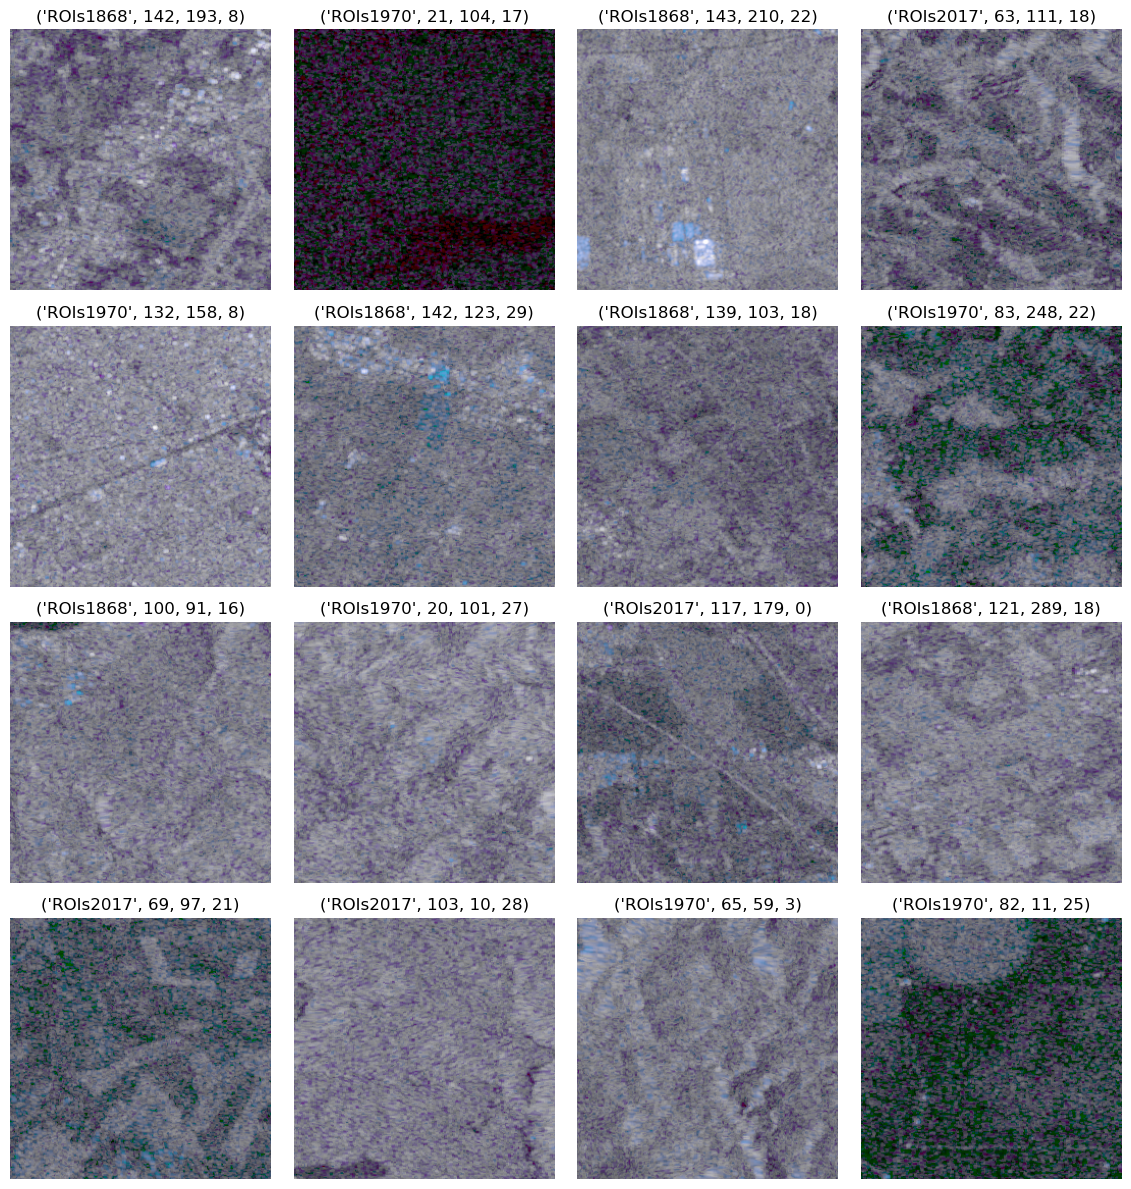

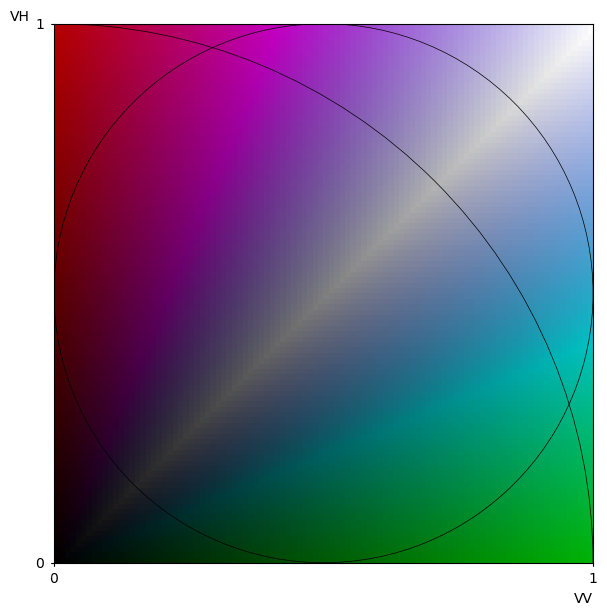

In [62]:
display(fig_4)
display(fig_5)
# display(widgets.HBox([fig_4.canvas, fig_5.canvas], layout=widgets.Layout(align_items="center")))

In [59]:
# plt.close(fig_4)

In [60]:
# plt.close(fig_5)